In [1]:
#implement decoder only transformer with subclassing api for language modelling
#use tiktoken as tokenizer
#implement multihead attention layer myself
#compare with built-in multihead attention
#train on tiny shakespeare dataset
#prepare autoregressive text generation and generate some fake Shakespeare

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys

try:
    import tiktoken
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tiktoken"])
    import tiktoken

import requests
print('Imports successful')

Imports successful


In [3]:
class Embedding(nn.Module):
  def __init__(self, d_model, vocab_size):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, d_model)

  def forward(self ,x):
    return self.embed(x)

In [4]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_seq_len=1024):
    super().__init__()
    self.d_model = d_model
    self.max_seq_len = max_seq_len
    # apparently this is necessary to move to gpu
    self.register_buffer('pe', self.calculate_pe(), persistent=False)

  def calculate_pe(self):
    pe = torch.zeros(self.max_seq_len, self.d_model)
    for i in range(int(self.d_model/2)):
      for pos in range(self.max_seq_len):
        pe[pos,2*i] = np.sin(pos/(10000**((2*i)/self.d_model)))
        pe[pos,2*i+1] = np.cos(pos/(10000**((2*i)/self.d_model)))
    return pe

  def forward(self, x):
    seq_length = x.shape[1]
    return x + self.pe[:seq_length, :]


In [5]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size, applyMask=True, dropout=0.0):
    super().__init__()
    self.head_size = head_size
    # head_size = d_k = d_model / n_heads
    self.query = nn.Linear(d_model, head_size)
    self.key = nn.Linear(d_model, head_size)
    # dv=dk here
    self.value = nn.Linear(d_model, head_size)
    self.softmax = nn.Softmax(dim=-1)
    self.applyMask = applyMask
    self.register_buffer('mask', self.createMask(), persistent=False)

    # Dropout
    self.dropout = nn.Dropout(p=dropout)


  def createMask(self, max_seq_len=1024):
    mask = torch.full((max_seq_len, max_seq_len), float('-inf'))
    mask = torch.triu(mask, diagonal=1)
    return mask


  def forward(self, x):
    seq_length = x.shape[1]
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)
    # we have to transpose K, the next line gives us
    # the attention matrix of shape (batch, seq_len, seq_len), telling us
    # how much token i attends to token j
    attention = Q @ torch.transpose(K,1,2) / np.sqrt(self.head_size)
    # we now have to apply masking before the softmax so that positions j>=i are ignored
    if self.applyMask is True: attention = attention + self.mask[:seq_length, :seq_length]
    # we apply dropout to zero out some attention weights randomly
    # that way we force the model to not rely too heavily on single token's attention
    attention = self.dropout(self.softmax(attention)) @ V
    return attention

In [6]:
class MultiHeadAttention(nn.Module):
  def __init__(self, AttentionHead, d_model, n_head, decoder=True, dropout=0.0):
    super().__init__()
    self.d_model = d_model
    self.n_head = n_head
    self.head_size = d_model // n_head
    self.heads = nn.ModuleList(
        [AttentionHead(self.d_model, self.head_size, decoder, dropout) for _ in range(self.n_head)]
        )
    # The concatenation happens such that only the last dimension is concatenated
    # because the heads each return attention of form (batch_size, seq_length, head_size)
    # since all parameters are the same, and only the head_size contains the actual embedding data
    # we just have to concatenate these while leaving batch_size and seq_length untouched
    # then the linear layer takes all these and mixes the information accross heads
    # linear layer has dimension (d_model x head_size * n_head = d_model x d_model)
    self.linear = nn.Linear(self.d_model, self.d_model)

  def forward(self, x):
    attention = torch.cat([head(x) for head in self.heads], dim=-1)
    return self.linear(attention)

In [7]:
class LayerNorm(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    # LayerNorm according to LN(x) = gamma *(x-mu)/sigma + beta
    self.d_model = d_model
    # gamma initialised to 1
    self.gamma = nn.Parameter(torch.ones(d_model))
    # beta (bias) to zero
    self.beta = nn.Parameter(torch.zeros(d_model))

  def forward(self, x):
    mean = torch.mean(x, dim=-1, keepdim=True)
    # correction is zero to get population std
    std = torch.std(x, dim=-1, correction=0, keepdim=True)
    return self.gamma*(x-mean)/std + self.beta


In [8]:
class FeedForward(nn.Module):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model
    self.dff = d_model * 4
    self.lin1 = nn.Linear(self.d_model, self.dff)
    self.relu = nn.ReLU()
    self.lin2 = nn.Linear(self.dff, self.d_model)

  def forward(self, x):
    out = self.lin1(x)
    out = self.relu(out)
    out = self.lin2(out)
    return out


In [9]:
class AttentionBlock(nn.Module):
  def __init__(self, d_model, n_head, use_built_in=False, dropout=0.0):
    super().__init__()
    self.d_model = d_model
    self.n_head = n_head
    self.use_built_in = use_built_in
    # the only decoder model (gpt-2) has no Cross-Attention, and thus we omit the second MultiHeadAttention
    if self.use_built_in:
      self.MultiHeadAttention = nn.MultiheadAttention(self.d_model, n_head, dropout=0.1, batch_first=True)
    else:
      self.MultiHeadAttention = MultiHeadAttention(AttentionHead, self.d_model, self.n_head, decoder=True, dropout=dropout)
    self.LayerNorm1 = LayerNorm(self.d_model)
    self.FeedForward = FeedForward(self.d_model)
    self.LayerNorm2 = LayerNorm(self.d_model)

    # Dropout
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
    if self.use_built_in:
      mask = nn.Transformer.generate_square_subsequent_mask(x.shape[1], device=x.device)
      out, _ = self.MultiHeadAttention(x, x, x, attn_mask = mask)

    else:
      out = self.MultiHeadAttention(x)

    out = self.LayerNorm1(x + self.dropout(out))
    out = self.LayerNorm2(out + self.dropout(self.FeedForward(out)))
    return out



In [10]:
class Decoder(nn.Module):
  def __init__(self, d_model, n_head, n_layer, use_built_in=False, dropout=0.0):
    super().__init__()
    self.vocab_size = 50257
    self.d_model = d_model
    self.n_head = n_head
    self.n_layer = n_layer
    # flag whether we use pytorch's MultiHeadAttention or mine
    self.use_built_in = use_built_in
    self.Embedding = Embedding(self.d_model, vocab_size=self.vocab_size)
    self.PositionalEncoding = PositionalEncoding(self.d_model)
    self.Linear = nn.Linear(self.d_model, self.vocab_size)

    # Dropout
    self.dropout = nn.Dropout(p=dropout)

    self.DecoderBlock = nn.ModuleList(
        [AttentionBlock(self.d_model, self.n_head, self.use_built_in, dropout) for _ in range(n_layer)])

  def forward(self, x):
    # x is tokenized
    out = self.Embedding(x)
    out = self.dropout(self.PositionalEncoding(out))
    for block in self.DecoderBlock:
      out = block(out)
    out = self.Linear(out)
    # no SoftMax as CrossEntropy expects Raw Logits
    return out

In [11]:
"""
These Previous parameters lead to overfitting:
# Instantiate Decoder
d_model = 256
n_head = 8
n_layer = 4
seq_len = 96
batch_size = 48
model = Decoder(d_model, n_head, n_layer, use_built_in=True, dropout=0.1)
"""

'\nThese Previous parameters lead to overfitting:\n# Instantiate Decoder\nd_model = 256\nn_head = 8\nn_layer = 4\nseq_len = 96\nbatch_size = 48\nmodel = Decoder(d_model, n_head, n_layer, use_built_in=True, dropout=0.1)\n'

In [12]:
# Instantiate Decoder
d_model = 128
n_head = 4
n_layer = 2
seq_len = 64
batch_size = 96
dropout = 0.2
use_built_in = True
model = Decoder(d_model, n_head, n_layer, use_built_in=use_built_in, dropout=dropout)
model = torch.compile(model)

# Criterion
criterion = nn.CrossEntropyLoss()
steps = 50000
warm_up_steps = steps * 0.04
#warm_up_steps = steps * 0.25

# learning rate
def lr_scheduler(step, d_model, warm_up_steps):
  return d_model**(-0.5) * min(step**(-0.5), step * warm_up_steps**(-1.5))

# Optimizer
beta1 = 0.9
beta2 = 0.98
epsilon = 10**-9
optimizer = torch.optim.Adam(model.parameters(), lr=1.0, betas=(beta1, beta2), eps=epsilon)

In [13]:
# URL of the tiny Shakespeare dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

# Download the content
response = requests.get(url)
file_path = "data.txt"

# Save the content to a file
with open(file_path, "w", encoding="utf-8") as f:
    f.write(response.text)

In [14]:
# Define GPU if available:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [15]:
# Instantiate Tokenizer:
enc = tiktoken.get_encoding("gpt2")
vocab_size = enc.n_vocab
print(vocab_size) # 50257 is the vocab length

with open(file_path, 'r') as f:
  text = f.read()

# tokenize whole set
tokens = enc.encode(text)
data = torch.tensor(tokens)

# split into train/val set
split = int(len(data)*0.9)
train_data = data[:split]
val_data = data[split:]

def get_batch(data, seq_len, batch_size):
  start_pos = torch.randint(0, len(data)-seq_len-1, (batch_size,))
  inputs = torch.stack([data[i:i+seq_len] for i in start_pos])
  targets = torch.stack([data[i+1:i+seq_len+1] for i in start_pos])
  return inputs,targets



50257


In [ ]:
# "no epochs", because we're sampling
# random data from a big text file, doesn't matter

#on A100
torch.set_float32_matmul_precision('high')

train_losses = []
val_losses = []
lr_steps = []
best_val_loss = float('inf')

print("Starting training...")
for step in range(1, steps+1):
  # Set model to train mode
  model.train()

  # Calculate learning rate:
  lr = lr_scheduler(step, d_model, warm_up_steps)
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

  # append current learning rate
  lr_steps.append(lr)

  # get batch - fresh random sample
  inputs, targets = get_batch(train_data, seq_len, batch_size)

  # move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # zero grads
  optimizer.zero_grad()

  # get output - gives logits
  outputs = model(inputs)

  # logits format is (batch, seq_len, vocab_size)
  # loss function expects (batch, vocab_size, seq_len)
  # equiv to (batch, classes, sequence)
  loss = criterion(outputs.permute(0,2,1), targets)

  # backpropagate the loss
  loss.backward()

  # append loss
  train_losses.append(loss.item())

  # optimizer step, update weights
  optimizer.step()

  if step % 100 == 0:
    print(f'Step: {step}, Loss: {loss.item()}')

  if step % 250 == 0:
    model.eval()

    # disable gradient tracking
    with torch.no_grad():

      val_loss_samples = []

      # avergaging loss through a batch of val samples is better
      for _ in range(10):
        # get val batch
        inputs, targets = get_batch(val_data, seq_len, batch_size)

        # move to gpu
        inputs, targets = inputs.to(device), targets.to(device)

        # forward pass
        outputs = model(inputs)

        # calculate val loss
        val_loss = criterion(outputs.permute(0,2,1), targets)

        # append loss
        val_loss_samples.append(val_loss)

      val_loss = sum(val_loss_samples) / len(val_loss_samples)
      val_losses.append(val_loss.item())

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model_{steps/1000}k_NN_is_{use_built_in}_d{d_model}_nh{n_head}_nl{n_layer}_seq{seq_len}_bs{batch_size}_dp{dropout}.pth')
          
      print(f'Step: {step}, Loss: {loss.item()}, Val Loss: {val_loss}')


Starting training...
Step: 100, Loss: 9.409174919128418
Step: 200, Loss: 7.021591663360596
Step: 250, Loss: 6.326549053192139, Val Loss: 6.34756326675415
Step: 300, Loss: 6.072511196136475
Step: 400, Loss: 5.713167190551758
Step: 500, Loss: 5.365545272827148
Step: 500, Loss: 5.365545272827148, Val Loss: 5.545958042144775
Step: 600, Loss: 4.959665298461914
Step: 700, Loss: 4.631975173950195
Step: 750, Loss: 4.756529331207275, Val Loss: 5.06485652923584
Step: 800, Loss: 4.546237468719482
Step: 900, Loss: 4.345777988433838
Step: 1000, Loss: 4.154778957366943
Step: 1000, Loss: 4.154778957366943, Val Loss: 4.945488929748535
Step: 1100, Loss: 4.288694858551025
Step: 1200, Loss: 4.097249507904053
Step: 1250, Loss: 4.149986743927002, Val Loss: 5.008738994598389
Step: 1300, Loss: 3.9442689418792725
Step: 1400, Loss: 3.980916738510132
Step: 1500, Loss: 3.905238389968872
Step: 1500, Loss: 3.905238389968872, Val Loss: 5.166061878204346
Step: 1600, Loss: 3.8537137508392334
Step: 1700, Loss: 3.77849

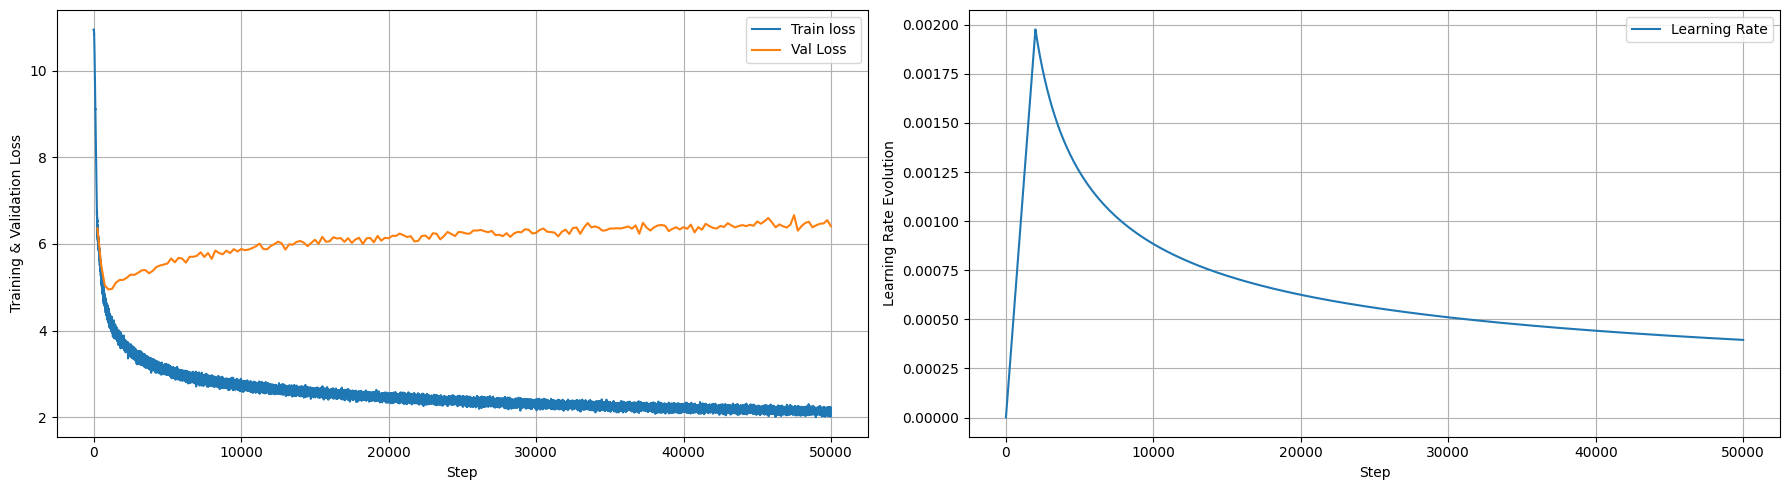

Saved training curves to training_curves.png


In [49]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(18,5))
x_steps = range(1, steps + 1)
eval_steps = range(250, steps+1, 250)

# Loss
axes[0].plot(x_steps, train_losses, label='Train loss')
axes[0].plot(eval_steps, val_losses, label='Val Loss')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_ylabel('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

# LR
axes[1].plot(x_steps, lr_steps, label='Learning Rate')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Learning Rate')
axes[1].set_ylabel('Learning Rate Evolution')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f'training_curves_{steps/1000}k_NN_is_{use_built_in}_d{d_model}_nh{n_head}_nl{n_layer}_seq{seq_len}_bs{batch_size}_dp{dropout}.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved training curves to training_curves.png")

In [ ]:
# Generate text autoregressively
def generate(model, prompt, max_new_tokens, temperature=1.0, seq_len=64):

  # set to eval mode
  model.eval()

  # tiktoken
  tokens = enc.encode(prompt)
  tokens = torch.tensor(tokens).unsqueeze(0).to(device)

  with torch.no_grad():
    text = []
    for _ in range(max_new_tokens):
      # truncate if context gets too large
      if tokens.shape[1] > seq_len:
        tokens = tokens[:, -seq_len:]

      # forward pass
      out = model(tokens)

      # get logits
      logits = out[:, -1, :]

      # divide by temperature
      # higher temperature = more randomness (like ising model)
      logits = logits / temperature

      # next token, probabilities
      probs = F.softmax(logits, dim=-1)

      # now sample from the probabilities to get next token
      # we take out a sample based on the prob distribution
      next_token = torch.multinomial(probs, num_samples=1)

      # append to tokens
      tokens = torch.cat([tokens, next_token], dim=1)
      text.append(enc.decode(next_token.squeeze(0).tolist()))

  return text

# first we load best model
model.load_state_dict(torch.load(f'best_model_{steps/1000}k_NN_is_{use_built_in}_d{d_model}_nh{n_head}_nl{n_layer}_seq{seq_len}_bs{batch_size}_dp{dropout}.pth'))

# generate some text
prompts = [
    "Generate some Shakespeare Text",
    "Generate something like Hamlet",
    "Generate a story about a King",
    "Generate a story about Krakow"
]
sample_text = generate(model, prompts[2], max_new_tokens=10000, temperature=1.0, seq_len=seq_len)
print(''.join(sample_text))

with open(f"generated_{steps/1000}k_NN_is_{use_built_in}_d{d_model}_nh{n_head}_nl{n_layer}_seq{seq_len}_bs{batch_size}_dp{dropout}.txt", "w", encoding="utf-8") as f:
    f.write(''.join(sample_text))


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/_inductor/lowering.py:7095: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(


 helmly frowns
To be Sar it, I have said blows,
That in Rome with our hand: who fruit:
Who redemptionilt cursed shall best to be punish.

SLY GREY:
could that's brow is
I may fl EDWARD IV: but not change'd you are disease
Which hardly
Angelo water 'el frown too much but a j so villain.
Thou had rather Tyb stiff back, you
Ourselves that he will yield queen!
And will rend it charging
On thy life the court, my recomp you turn seeing Thisse;
Much, or else thou livest-faced held
Show away for perpet Pluto unkind?

KING EDWARD IV:
Good heavens on, my throne steel; for their money toward;
And believe the heavensble tremb
If on despised.
After trial Carlieu; and talk. First's buttrive madam,
You'll tell me a bloody dag body with heavy tear,
Tis.
Y ANNE:
Very?


Clown:
Opard, as right woman, I did swear, if you must be framed
Hastim evercher!

QUEEN MARGARET:
im! You isea, think the top liest plead our hands, faith
In an adult earth to put to contrary.

GLOUCESTER:
Prithee! what which Mercut an

More importantly though — accuracy is a misleading metric for language models. Think about it — if the target is "the" (most common English word), the model can get high accuracy just by always predicting "the". Loss tells you much more about how confident and correct the model is across the whole vocabulary distribution.